In [1]:
import jupyter_black

import os, sys
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from PIL import Image

if not "/usr/src" in sys.path:
    sys.path.append("/usr/src")

jupyter_black.load()

In [2]:
# Custom modules
from dataset import create_cell_dataset, augmentation_cells
from unet import UNet
from diffusion import Diffusion
from utils_diffusion import train, count_fid_metric, show_grid_samples, generate_and_save_samples

In [16]:
# Dirs
cell_dir = "/usr/src/separated_cells"
new_cell_dir = "/usr/src/separated_cells_new"
sample_dir = "/usr/src/samples_cell"

In [ ]:
# Expanding of cell dataset using trabsforms
augmentation_cells(cell_dir, new_cell_dir)

In [4]:
train_size = len(os.listdir(new_cell_dir)) - 100
test_size = 100

image_size = 64
channels = 1
batch_size = 70
device = "cuda" if torch.cuda.is_available() else "cpu"

cell_dataset = create_cell_dataset(new_cell_dir, image_size)

train_dataset, test_dataset = random_split(cell_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

# train_loader = DataLoader(cell_dataset, batch_size=batch_size, shuffle=True)

In [5]:
model = UNet(
    img_dim=image_size,
    img_channels=channels,
    in_channels=32,
    channel_mults=(1, 2, 4, 8),
)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [5]:
# Initialization of the diffusion

timesteps = 400
diffusion = Diffusion(timesteps)

In [ ]:
# Training

epochs = 25
log_path = "logging_cells"
log_interval = len(train_loader) // 4

loss_progress = train(
    model, diffusion, timesteps, train_loader, epochs, optimizer, device, log_path, log_interval
)

Text(0.5, 1.0, 'Loss per each step')

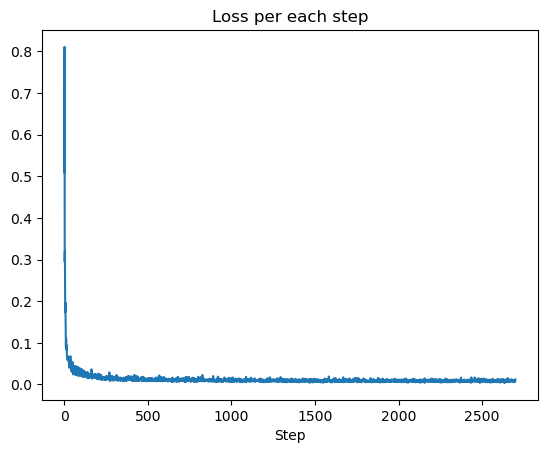

In [11]:
plt.plot(loss_progress)
plt.xlabel("Step")
plt.title("Loss per each step")

In [12]:
torch.save(model, f"cell_denoise_model_{epochs}_epochs.pt")

In [ ]:
model = torch.load("cell_denoise_model_25_epochs.pt")
model.eval()

sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

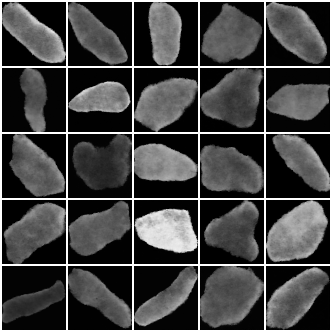

In [12]:
# Create grid of generated samples and show it

n_samples = 25
samples = show_grid_samples(
    n_samples, diffusion, model, image_size, channels, "grid_samples"
)

In [17]:
# Generate many new separate samples and save them

from utils_diffusion import generate_and_save_samples

generate_and_save_samples(sample_dir, 20, diffusion, model, image_size, channels)

sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

In [17]:
# Count FID metric

print(
    count_fid_metric(
        test_loader, diffusion, model, image_size, channels, [64, 192, 768, 2048]
    )
)

sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

[tensor(2.0689), tensor(12.7703), tensor(1.1748), tensor(176.7931)]
